In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm
from data import fMRIData, fMRIDataEval, LUNA, LUNAEval
from operators import MRI, Operator, CT
from torch import nn
from torch.utils.data import DataLoader
from networks import ResNet, ConvNet, ConvenientModel
import torch
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
from utils import Norm, mkdir
import json

In [2]:
# Saves
BASE_PATH = '/store/CCIMI/sl767/Experiments/'

In [16]:
# EXPERIMENT = 'MRI_fMRIData_Sobolev_-5e-1_Exp_1'
# EXPERIMENT = 'CT_LUNA_Sobolev_-1_Exp_4_PS_1'
# EXPERIMENT = 'CT_LUNA_Sobolev_-1_Exp_5_PS_15'
EXPERIMENT = 'CT_LUNA_Sobolev_0_Exp_3'

### Reading out experiment parameters as default parameters
with open(BASE_PATH + EXPERIMENT + '/param.json', "r") as read_file:
    parameters = json.load(read_file)
for k, v in parameters.items():
    exec (k + '=v')
    print(k, v)
    
### Reading out the optimal application parameters
if os.path.exists(os.path.join(BASE_PATH, EXPERIMENT, 'optimal_application_param.json')):
    with open(os.path.join(BASE_PATH, EXPERIMENT, 'optimal_application_param.json'), "r") as read_file:
        optimal_applic_para = json.load(read_file)
        for k, v in optimal_applic_para.items():
            print(k, v)
else:
    optimal_applic_para = {}
    print('No optimal parameteres found')

DATASET LUNA
MODALITY CT
NOISE_LEVEL 0.002
N_ANGLES 100
INITIAL_MINIMIZATION False
LEARNING_RATE 0.0001
APPLY_RESCALING False
DECAY_FACTOR 0.7
DECAY_EVERY_NSTEPS 5000
BATCH_SIZE 16
TRAINING_STEPS 20000
CHANNELS [1, 64, 128, 128]
DOWNSAMPLING [False, True, True]
SOBOLEV 0
PIXEL_SIZE 1
MU 1
N_STEPS 120
STEP_SIZE 0.1
THRESHOLDING False
N_IMAGES_LOGGING 1
TRACKING_FREQ 100
AVERAGE_NOISE_NORM 12.69339370727539
AVERAGE_NOISE_DUAL 12.69339370727539
AVERAGE_IMAGE_NORM 129.489990234375
AVERAGE_DUAL_NORM 129.489990234375
LAMBDA 0.02329254522919655
No optimal parameteres found


In [4]:
### Parameter overwrite for experimentation

# Data Setup
# DATASET = 'fMRI'
# MODALITY= 'MRI'
# NOISE_LEVEL = 1e-3
# N_ANGLES = 60
# INITIAL_MINIMIZATION = False

# DATASET = 'LUNA'
# MODALITY= 'CT'
# NOISE_LEVEL = 2e-3
# N_ANGLES = 100
# INITIAL_MINIMIZATION = False

In [5]:
norm = Norm(s = SOBOLEV, c = 1/PIXEL_SIZE)
dual = norm.dual
if MODALITY == 'MRI':
    operator = MRI(n_directions=N_ANGLES)
elif MODALITY == 'CT':
    operator = CT(n_angles=N_ANGLES)
if DATASET == 'fMRI':
    data = DataLoader(fMRIData(), batch_size=BATCH_SIZE, num_workers=4)
    val_data = DataLoader(fMRIDataEval(), batch_size=BATCH_SIZE)
elif DATASET == 'LUNA':
    data = DataLoader(LUNA(), batch_size=BATCH_SIZE, num_workers=4)
    val_data = DataLoader(LUNAEval(), batch_size=BATCH_SIZE)
operator

Number of training samples found 76138
Number of training samples found 14515


CT Operator
Resolution 256
Angles: 100

In [6]:
regulariser = ResNet(channels=CHANNELS, downsamples=DOWNSAMPLING, base_path=BASE_PATH, exp_name=EXPERIMENT).cuda()

Model loaded. Step 20000


In [7]:
def get_training_data(gt, initial_minimisation=False):
    y = operator.add_noise(operator.forward_torch(gt), NOISE_LEVEL)
    x_0 = operator.inverse_torch(y)
    # potentially add a solution of variational problem at this point
    if initial_minimisation:
        x_0 = solve_variational_problem(x_0, y, 10, .1, 0, tracking=None)
    return x_0, y
def l2(x):
    return torch.mean(torch.sqrt(torch.sum(x ** 2, dim=(1,2,3))))

In [59]:
def solve_variational_problem(x_0, y, x_gt, n_steps=N_STEPS, step_size=STEP_SIZE, lam=LAMBDA, thresholding=THRESHOLDING, image_tracking_freq=5, verbose=True, log_images=False):
    '''
    Solves the variational problem starting at x_0, with data term y, n_steps
    descent steps and regularisation paremeter mu.
    '''
    loggings = {}
    
    def add_scalar(name, value, iteration):
        if name not in loggings.keys():
            loggings[name] = {}
        loggings[name][iteration] = value

    def add_image(name, value, iteration):
        if name not in loggings.keys():
            loggings[name] = {}
        if iteration%image_tracking_freq == 0 and log_images:
            loggings[name][iteration] = value
            if verbose:
                plt.figure(figsize=(10,10))
                plt.imshow(value[0,0,...])
                plt.axis('off')
                plt.show()

    best_per = -1
    best_attained_at = -1
    best_recon = None
    x = x_0.detach()
    for k in range(n_steps):
        data_term = operator.forward_torch(x) - y
        add_scalar('Data_Term', l2(data_term).detach().cpu().numpy()/2, k)
        data_grad = operator.adjoint_torch(data_term)
        add_scalar('L2_Data_Gradient', l2(data_grad).detach().cpu().numpy(), k)
        add_scalar('Dual_Norm_Data_Gradient', torch.mean(dual(data_grad)).detach().cpu().numpy(), k)
        quality = (l2(x_gt - x)).mean().detach().cpu().numpy()
        if quality < best_per or best_per == -1:
            best_attained_at = k
            best_per = quality
            best_recon = x.detach().cpu().numpy()
        add_scalar('Quality', quality, k)
        add_image('Reconstruction', x.cpu().numpy(), k)

        # Getting the regulariser gradient
        reg_grad =  regulariser.gradient(x)
        add_scalar('L2_Regulariser_Gradient', l2(reg_grad).detach().cpu().numpy(), k)
        add_scalar('Dual_Norm_Regulariser_Gradient', torch.mean(dual(reg_grad)).detach().cpu().numpy(), k)
        x = x - step_size * (data_grad + lam * reg_grad)
        
        # Apply thresholding
        if thresholding:
            x = torch.clamp(x, 0, 1)
    
    # Log the global optimum seperately
    loggings['Reconstruction_Quality'] = best_per
    loggings['Best_Attained_At'] = best_attained_at
    loggings['Best_Reconstruction'] =  best_recon
    loggings['Ground Truth'] = x_gt.cpu().numpy()
    loggings['FBP'] = x_0.cpu().numpy(),

    return loggings, x

In [66]:
val_gt = next(iter(val_data)).cuda()
val_fbp, val_y = get_training_data(val_gt)
results = {}

In [ ]:
N_STEPS = 300
STEP_SIZE = 1
THRESHOLDING = False
lambdas = [LAMBDA/8, LAMBDA/4, LAMBDA/2, LAMBDA, 2*LAMBDA, 4*LAMBDA, 8*LAMBDA]
for l in lambdas:
    print('Lambda', l)
    logs, _ = solve_variational_problem(val_fbp, val_y, val_gt, step_size=STEP_SIZE, n_steps=N_STEPS, lam=l, verbose=False)
    results[l] = logs

Lambda 0.0029115681536495686


In [ ]:
metrics = ['Quality', 'Data_Term', 'Dual_Norm_Data_Gradient', 'Dual_Norm_Regulariser_Gradient']
for m in metrics:
    print(m)
    plt.figure(figsize=(6,6))
    for l in lambdas:
        plt.plot(results[l][m].keys(), results[l][m].values(), label=l)
    plt.legend()
    plt.show()

In [ ]:
# Manually chose optimal hyperparameter
LAMBDA = 0.02329254522919655
print(results[LAMBDA]['Reconstruction_Quality'])

In [34]:
results[LAMBDA].keys()

dict_keys(['Data_Term', 'L2_Data_Gradient', 'Dual_Norm_Data_Gradient', 'Quality', 'Reconstruction', 'L2_Regulariser_Gradient', 'Dual_Norm_Regulariser_Gradient', 'Reconstruction_Quality', 'Best_Attained_At', 'Ground Truth', 'FBP'])

(-0.5, 255.5, 255.5, -0.5)

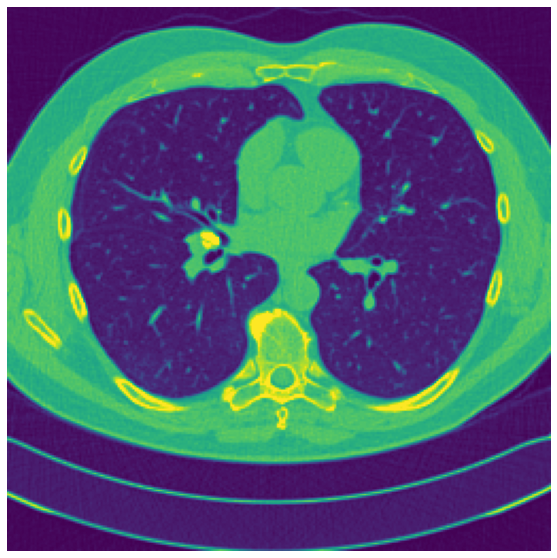

In [57]:
i = 3
plt.figure(figsize=(10,10))
plt.imshow(results[LAMBDA][Best_Reconstruction'][i,0,...])
plt.axis('off')

In [ ]:
### Add current experiment to optimal hyperparameters
optimal_application_param[f'{DATASET}_{MODALITY}_{NOISE_LEVEL}_{N_ANGLES}'] = 
{
    'LAMBDA': LAMBDA,
    'N_STEPS': N_STEPS,
    'STEP_SIZE': STEP_SIZE,
    'STEP_SIZE': STEP_SIZE,
    'QUALITY': results[LAMBDA]['Reconstruction_Quality']
}

In [ ]:
# We write the optimal hyperparameters to file
with open(os.path.join(BASE_PATH, EXPERIMENT, 'optimal_application_param.json'),"w") as f:
    json.dump(parameters, f)
    print('Optimal parameters saved')

In [60]:
# We write the optimal reconstructions to file as npy and as images
saves_path = os.path.join(BASE_PATH, EXPERIMENT, f'{DATASET}_{MODALITY}_{NOISE_LEVEL}_{N_ANGLES}')
mkdir(saves_path)
# Save numpy arrays
np.save(os.path.join(saves_path, 'GT.npy'), results[LAMBDA]['Ground Truth'])
np.save(os.path.join(saves_path, 'FBP.npy'), results[LAMBDA]['FBP'])
# np.save(os.path.join(saves_path, 'Reconstruction.npy'), results[LAMBDA]['Best_Reconstruction'])
# Save individual images
for i in range(BATCH_SIZE):
    for method in ['Ground Truth', 'FBP', 'Best_Reconstruction']:
        plt.figure(figsize=(10,10))
        plt.imshow(results[LAMBDA][method][i,0,...])
        plt.axis('off')
        plt.savefig(os.path.join(saves_path, f'{method}_{i}.png'), transparent=True)
        plt.close

Created directory /store/CCIMI/sl767/Experiments/CT_LUNA_Sobolev_0_Exp_3/LUNA_CT_0.002_100


KeyError: 'Best_Reconstruction'